In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# from dask.distributed import Client, LocalCluster
# cluster = LocalCluster(memory_limit='16GB')
# client = Client(cluster)
# client

In [3]:
import sys
from pathlib import Path
import pandas as pd
import tarfile
import urllib

def load_metadata():
  file_path = Path("data/train.csv")
  return pd.read_csv(file_path)
  
metadata = load_metadata()

def extract_eeg():
  eeg_dir = Path("../data/eeg")
  tarball_path = Path("data/eeg.tar.gz")
  if not tarball_path.is_file():
    url = 'https://dl.dropboxusercontent.com/scl/fi/5sina48c4naaxv6uze0fv/eeg.tar.gz?rlkey=r7ec191extynfcm8fy0tsiws5&dl=0'
    urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as eeg_tarball:
      eeg_tarball.extractall()
    
extract_eeg()

metadata

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,4144388963,140,604.0,1156825996,140,604.0,1451266906,59489,GRDA,0,0,0,0,3,0
1,2353475448,30,64.0,1002394133,30,64.0,4000072340,5339,LRDA,0,0,0,3,0,0
2,1618328341,9,52.0,900482955,9,52.0,4140697659,20198,GRDA,0,0,0,0,3,0
3,979865826,7,90.0,1626043434,7,90.0,919550440,1069,Other,1,1,4,1,4,5
4,521108392,0,0.0,827447277,0,0.0,1717414556,13134,Other,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2509824693,10,68.0,1005228554,15,330.0,219919562,14386,LPD,0,11,0,1,1,2
996,2882719839,14,50.0,2035369578,14,50.0,4193559045,2641,GPD,5,0,11,0,0,0
997,1322226281,2,18.0,1740512896,2,18.0,1697286566,49448,Other,0,0,0,0,0,3
998,628369060,15,98.0,13143748,17,292.0,1650460145,34998,GPD,0,3,7,0,2,4


In [4]:
# Add a unique id to each sample
from src.utils.utils import compute_signal_hash

def compute_unique_id(row):
  return str(compute_signal_hash(row))

metadata['unique_id'] = metadata.apply(compute_unique_id, axis=1)

cols = metadata.columns.tolist()
cols = [cols[-1]] + cols[:-1]
metadata = metadata[cols]
metadata


,unique_id,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,db76e9927,4144388963,140,604.0,1156825996,140,604.0,1451266906,59489,GRDA,0,0,0,0,3,0
1,0e1116d9d,2353475448,30,64.0,1002394133,30,64.0,4000072340,5339,LRDA,0,0,0,3,0,0
2,8ec6d3c8c,1618328341,9,52.0,900482955,9,52.0,4140697659,20198,GRDA,0,0,0,0,3,0
3,662b0bd39,979865826,7,90.0,1626043434,7,90.0,919550440,1069,Other,1,1,4,1,4,5
4,ca946aadb,521108392,0,0.0,827447277,0,0.0,1717414556,13134,Other,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,368247dd8,2509824693,10,68.0,1005228554,15,330.0,219919562,14386,LPD,0,11,0,1,1,2
996,a7a60ad75,2882719839,14,50.0,2035369578,14,50.0,4193559045,2641,GPD,5,0,11,0,0,0
997,97f63909c,1322226281,2,18.0,1740512896,2,18.0,1697286566,49448,Other,0,0,0,0,0,3
998,a5399830b,628369060,15,98.0,13143748,17,292.0,1650460145,34998,GPD,0,3,7,0,2,4


In [5]:
import dask.dataframe as dd
from src.utils import compute_signal_hash

channel_order = ['Fp1', 'Fp2',
            'F7', 'F3', 'Fz', 'F4', 'F8', 
            'T3', 'C3', 'Cz', 'C4', 'T4', 
            'T5', 'P3', 'Pz', 'P4', 'T6', 
            'O1', 'O2',
          ]

def load_signals(metadata):
  rows = len(metadata)
  eeg_list = []

  for row in range(0,rows):
    sample = metadata.iloc[row]
    f_name = f'data/eeg/{sample.eeg_id}.parquet'
    eeg = pd.read_parquet(f_name)[channel_order]
    eeg_offset = int(sample.eeg_label_offset_seconds)

    eeg['unique_id'] = sample['unique_id']
    eeg = eeg.set_index('unique_id')

    eeg = eeg.iloc[eeg_offset*200:(eeg_offset+50)*200]
    eeg_list.append(eeg)

  return dd.concat(eeg_list)

ddf = load_signals(metadata)


In [6]:
# Compute 150 signals to start
df = ddf.compute()
eeg_ids = list(set(df.index))
df

,Fp1,Fp2,F7,F3,Fz,F4,F8,T3,C3,Cz,C4,T4,T5,P3,Pz,P4,T6,O1,O2
unique_id,,,,,,,,,,,,,,,,,,,
db76e9927,-14.780000,-33.049999,-8.910000,-5.600000,-21.650000,1.780000,-26.129999,9.850000,-16.209999,-33.310001,-17.459999,3.22,-5.170000,-14.370000,-13.94,-24.629999,-4.620000,-27.780001,-17.980000
db76e9927,-8.100000,-34.610001,-26.570000,-2.770000,-20.350000,0.660000,-35.130001,13.400000,-16.600000,-36.060001,-17.309999,15.12,-3.140000,-15.580000,-15.91,-25.969999,-1.740000,-28.480000,-20.629999
db76e9927,-3.530000,-34.709999,17.120001,15.570000,-19.110001,-0.770000,-24.709999,30.219999,-8.930000,-32.369999,-23.840000,-2.82,14.670000,-6.310000,-8.61,-20.760000,4.840000,-18.500000,-10.460000
db76e9927,-3.370000,-29.330000,13.520000,11.710000,-20.629999,-4.140000,10.330000,24.660000,-10.640000,-33.750000,-32.400002,-4.81,14.880000,-5.840000,-11.61,-24.910000,-2.940000,-18.680000,-13.950000
db76e9927,-3.830000,-27.459999,14.320000,-2.420000,-20.000000,-3.300000,-9.990000,19.590000,-12.090000,-35.860001,-27.650000,7.83,4.900000,-11.270000,-16.00,-27.860001,-4.780000,-25.540001,-20.190001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
bbdf2f28e,-39.990002,-11.380000,14.590000,-20.500000,-15.240000,-23.340000,-57.529999,-12.530000,7.420000,-20.930000,-16.010000,1.68,-3.070000,-1.150000,2.43,-0.170000,-23.500000,-6.850000,3.350000
bbdf2f28e,-74.470001,-50.410000,-10.230000,-46.110001,-35.630001,-53.380001,-85.099998,-32.070000,-14.630000,-38.250000,-40.669998,-25.49,-22.780001,-22.990000,-15.43,-26.559999,-49.869999,-26.160000,-22.389999
bbdf2f28e,-66.209999,-31.180000,-4.690000,-39.560001,-26.389999,-49.680000,-75.089996,-27.030001,-7.510000,-28.959999,-32.930000,-10.00,-10.790000,-11.880000,-5.56,-20.100000,-42.110001,-11.150000,-14.310000


In [7]:
# Apply filtering
from src.preprocessing.preprocessing import bp_filter, notch_filter
from scipy.signal import iirnotch, filtfilt, butter

def apply_notch_filter(df, fs, f0):
  filtered = df.copy()
  b,a = iirnotch(f0, 30, fs)
  for column in filtered.columns:
    filtered[column] = filtfilt(b, a, df[column])
  return filtered

def apply_bp_filter(df, fs, lowcut, highcut):
  filtered = df.copy()
  nyq = 0.5*fs
  low = lowcut / nyq
  high = highcut/nyq
  b,a = butter(5, [low,high], btype='band')
  for channel in filtered.columns:
    filtered[channel] = filtfilt(b,a, df[channel])
  return filtered


filtered_data = apply_notch_filter(df, 200, 60)
filtered_data = apply_bp_filter(filtered_data, 200, 0.5, 50)

/opt/anaconda3/envs/340-project/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# df
# from src.preprocessing.preprocessing import wavelet_transform
# from src.visualize import plot_signal
# import numpy as np

# sig = df.loc['db76e9927']
# plot_signal(sig, 5, ['F3',	'Fz',	'F4',	'F8',	'T3'])


In [9]:
from src.preprocessing.preprocessing import wavelet_transform
sig_denoised = wavelet_transform(df, 2, basis='bior3.3')

Extracting top 3 channels based on max variance for all samples
- 1000 samples computation duration = approx. 15 minutes

In [10]:
from src.feature_extraction import calculate_all_samples

top_channels_df = calculate_all_samples(sig_denoised, eeg_ids, len(eeg_ids))
top_channels_df

,0,1,2
1ab60e9eb,Fp1,Fp2,Fz
0737f423f,Cz,C3,C4
10060abc4,P4,O2,O1
e1b1cccf9,Fp1,F8,Fp2
f1a1f5cca,Fp2,Fz,Fp1
...,...,...,...
c938c8d44,F7,T3,Fp1
4127ebe87,O2,F8,O1
2aaabc680,F7,Fp1,T3
d624eb84f,T3,F7,C3


Extracting Statistical Features from every sample with extraction function
- 1000 samples computation duration = approx. 20 minutes

In [11]:
from src.feature_extraction import extract_features_all_samples

features_df = extract_features_all_samples(df, top_channels_df)
features_df

,std,mean,max,min,var,med,skew,kurt,ent,mom,pow
1ab60e9eb,165.123652,0.054222,458.74,-557.936666,28419.158203,4.44,-0.141339,2.917779,5.051161,2514407978.666667,2841919053059.075684
0737f423f,69.793405,-25.085277,98.036667,-274.76,4944.190186,-0.265,-1.339697,3.986536,5.164254,102388692.0,584347541539.762817
10060abc4,140.868898,-19.166429,237.776667,-273.120005,22913.532227,-20.101666,0.063256,1.857436,4.3661,1081959486.666667,2333584670770.687012
e1b1cccf9,70.048836,-8.632403,245.996668,-242.950007,4915.197591,-4.211667,-0.262543,2.90151,5.01693,70098802.666667,543518836090.390808
f1a1f5cca,63.616295,-0.80974,275.579997,-304.25,4048.621419,-0.615,-0.251757,4.523675,5.420526,74572589.333333,405062126044.222229
...,...,...,...,...,...,...,...,...,...,...,...
c938c8d44,38.056802,-7.215365,121.296666,-145.403338,1452.412964,-10.055,0.187913,3.485355,5.103809,7135224.0,200588845004.533325
4127ebe87,204.175919,1.675729,554.119995,-703.526662,43298.88151,0.586666,-0.240103,5.520358,5.582654,11183250602.666666,4421175345726.977539
2aaabc680,47.141696,-15.294454,117.143331,-180.240005,2224.82019,-16.515,-0.041433,2.990492,5.056946,14911540.0,248516072472.493439
d624eb84f,25.847098,-18.400578,72.133334,-100.93,670.492655,-18.786667,0.077419,2.738523,5.014891,1231961.645833,109253907076.743057


Setting up Feature Data and Target Data for correct format to split data and Input to Microsoft's Light Gradient Boosting Machine (LGBM)

In [12]:
# Setup feature table
# input_df = pd.merge(features_df, metadata[['unique_id', 'seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']], left_index=True, right_on='unique_id')
input_df = pd.merge(features_df, metadata[['unique_id', 'expert_consensus']], left_index=True, right_on='unique_id')
input_df = input_df.set_index('unique_id')
input_df

,std,mean,max,min,var,med,skew,kurt,ent,mom,pow,expert_consensus
unique_id,,,,,,,,,,,,
1ab60e9eb,165.123652,0.054222,458.74,-557.936666,28419.158203,4.44,-0.141339,2.917779,5.051161,2514407978.666667,2841919053059.075684,Seizure
0737f423f,69.793405,-25.085277,98.036667,-274.76,4944.190186,-0.265,-1.339697,3.986536,5.164254,102388692.0,584347541539.762817,GPD
10060abc4,140.868898,-19.166429,237.776667,-273.120005,22913.532227,-20.101666,0.063256,1.857436,4.3661,1081959486.666667,2333584670770.687012,LRDA
e1b1cccf9,70.048836,-8.632403,245.996668,-242.950007,4915.197591,-4.211667,-0.262543,2.90151,5.01693,70098802.666667,543518836090.390808,LPD
f1a1f5cca,63.616295,-0.80974,275.579997,-304.25,4048.621419,-0.615,-0.251757,4.523675,5.420526,74572589.333333,405062126044.222229,Seizure
...,...,...,...,...,...,...,...,...,...,...,...,...
c938c8d44,38.056802,-7.215365,121.296666,-145.403338,1452.412964,-10.055,0.187913,3.485355,5.103809,7135224.0,200588845004.533325,LRDA
4127ebe87,204.175919,1.675729,554.119995,-703.526662,43298.88151,0.586666,-0.240103,5.520358,5.582654,11183250602.666666,4421175345726.977539,LPD
2aaabc680,47.141696,-15.294454,117.143331,-180.240005,2224.82019,-16.515,-0.041433,2.990492,5.056946,14911540.0,248516072472.493439,LRDA


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


x = input_df.iloc[:, :11].astype(float)
y = input_df[['expert_consensus']].to_numpy().flatten()

categories = ['Seizure', 'LPD', 'GPD', 'LRDA', 'GRDA', 'Other']

le = LabelEncoder()
le.fit(categories)
y = le.transform(y)


X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=68)

Inputting Parameters for LGBM Model
- parameters were obtained by observing similiar implementation in same competition project using LGBM library. (see report doc --> citations/acknowledgements for more details) 
- Slight adjustments to parameters applied to fit our implementation

In [27]:
# Training Model
from src.eeg_classifier import data_preprocessing, model, evaluation

X_train, X_test, y_train, y_test, le = data_preprocessing.prepare_data(input_df, categories)
lgb_model = model.train_model(X_train, y_train)
y_pred = lgb_model.predict(X_test)

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.756777580360579, subsample=1.0 will be ignored. Current value: bagging_fraction=0.756777580360579
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.756777580360579, subsample=1.0 will be ignored. Current value: bagging_fraction=0.756777580360579
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

Splitting Data 80/20 and adjusting params to obtain training and testing sets

Training our LGBM model on the training data and evaluating it on the test data - Probabilities for each target label are obtained and Displayed

Generating Confusion Matrix with predicted labels and true labels

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.756777580360579, subsample=1.0 will be ignored. Current value: bagging_fraction=0.756777580360579
Accuracy: 0.365
Precision: 0.35174400764086683
Recall: 0.365
F1 Score: 0.35174795942083237
     seizure_vote  lpd_vote  gpd_vote  lrda_vote  grda_vote  other_vote
0        0.208957  0.185328  0.169821   0.055531   0.131527    0.248836
1        0.121178  0.445199  0.091571   0.076552   0.073226    0.192274
2        0.160242  0.079187  0.137899   0.032019   0.070099    0.520554
3        0.193680  0.084296  0.113995   0.112385   0.117565    0.378078
4        0.059949  0.542211  0.100410   0.046430   0.194630    0.056370
..            ...       ...       ...        ...        ...         ...
195      0.074651  0.069037  0.072408   0.102634   0.281496    0.399774
196      0.124331  0.330323  0.089161   0.364640   0.053612    0

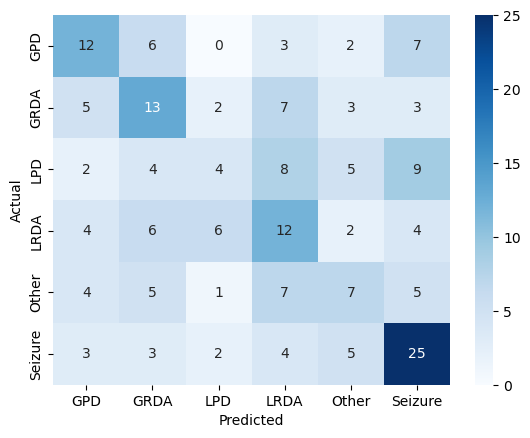

In [31]:
# Generate confusion matrix and evaluation
pred_df = evaluation.predict_probabilities(lgb_model, X_test)
evaluation.evaluate_model(y_test, y_pred, le)
print(pred_df)

Generating result metrics to evaluate our multiclassification model

In [17]:
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# # Calculate the metrics
# accuracy = accuracy_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred, average='weighted')
# recall = recall_score(y_test, y_pred, average='weighted')
# f1 = f1_score(y_test, y_pred, average='weighted')

# print(f'Accuracy: {accuracy}')
# print(f'Precision: {precision}')
# print(f'Recall: {recall}')
# print(f'F1 Score: {f1}')

Accuracy: 0.35
Precision: 0.3519564107296665
Recall: 0.35
F1 Score: 0.34946414061529246


In [18]:
y_pred_proba = lgb_model.predict_proba(X_test)

# Predicted probabilities to DataFrame
pred_df = pd.DataFrame(y_pred_proba, columns=['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote'])
pred_df['eeg_id'] = X_test.index
pred_df = pred_df[['eeg_id', 'seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']]
pred_df

,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,365a12b8d,0.026331,0.296630,0.130235,0.002250,0.129295,0.415259
1,7b4ad7da9,0.028449,0.886919,0.005163,0.015100,0.004801,0.059568
2,971e84404,0.003851,0.021944,0.041300,0.000058,0.002008,0.930840
3,fdd305b6a,0.275865,0.034446,0.089887,0.005852,0.097199,0.496751
4,439700210,0.004687,0.952946,0.008601,0.001203,0.027128,0.005435
...,...,...,...,...,...,...,...
195,3ba3d8156,0.002774,0.008500,0.114764,0.166397,0.058063,0.649502
196,550e5f044,0.009869,0.175746,0.009192,0.802337,0.000995,0.001862
197,e69d9bb62,0.013788,0.017212,0.005920,0.004930,0.829562,0.128588
198,d63827f34,0.963357,0.001203,0.001283,0.013779,0.015110,0.005269


Preprocessing Data: Applying Wavelet Transform, Notch filter, Standardization to our data
- Model was trained without preprocessing due to higher scores without

In [19]:
# File created to test the correctness of extracted values using MATLAB
# Save Fp1 channel data into a MATLAB file
# import scipy.io
# scipy.io.savemat('Fp1_data.mat', {'Fp1_data': sig1['Fp1']})